### Speech Entity Recognition (SER)

#### In this code, I'll be:
- Extracting the audio out of the video.
- Segmenting audio into *n* subaudios, in order to apply audio analysis.
- Integrating audio analysis on the data, in order to detect the audio emotion in every second.

In [1]:
# Libraries

import os
import math
import matplotlib.pyplot as plt
from collections import Counter
from scipy.io import wavfile
from moviepy.editor import VideoFileClip, AudioFileClip
import torchaudio
import torch
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification

In [2]:
# Emotions mapping

EMOTIONMAP = {0: 'Neutral', 1: 'Angry', 2: 'Happy', 3: 'Sad', 4: 'Other'}

In [3]:
# Initialize models

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")

Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

In [4]:
# Functions

def extract_audio_from_video(video_file, output_audio_file):
    video = VideoFileClip(video_file)
    audio = video.audio
    audio.write_audiofile(output_audio_file)
    print(f"Audio extracted and saved to {output_audio_file}")

def convert_mp3_to_wav_moviepy(mp3_file_path, wav_file_path):
    audio_clip = AudioFileClip(mp3_file_path)
    audio_clip.write_audiofile(wav_file_path, codec='pcm_s16le')
    os.remove(mp3_file_path)

def process_audio_segment(segment_waveform):
    inputs = feature_extractor(
        segment_waveform, 
        sampling_rate=feature_extractor.sampling_rate, 
        return_tensors="pt",
        padding=True,
        max_length=16000 * 1,
        truncation=True
    )
    logits = model(inputs['input_values'][0]).logits
    prediction = torch.argmax(logits, dim=-1)
    return EMOTIONMAP[prediction.numpy()[0]]

def split_and_process_audio(filename, segment_length):
    sample_rate, waveform_np = wavfile.read(filename)
    waveform = torch.from_numpy(waveform_np).float().transpose(0, 1)
    transform = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = transform(waveform)

    segment_size = 16000 * segment_length
    num_segments = math.ceil(waveform.size(1) / float(segment_size))
    return [process_audio_segment(waveform[:, i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)]

def plot_emotion_distribution(emotions):
    emotion_counts = Counter(emotions)
    print(emotion_counts)
    plt.figure(figsize=(8, 8))
    plt.pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Emotion Distribution in Audio')
    plt.savefig('output/emotion_distribution_audio_pie_chart.png', format='png', bbox_inches='tight')
    plt.show()

def process_audio(video_file, segment_length):
    base_name = os.path.splitext(os.path.basename(video_file))[0]
    audio_file_mp3 = f'{base_name}.mp3'
    audio_file_wav = f'{base_name}.wav'

    extract_audio_from_video(video_file, audio_file_mp3)
    convert_mp3_to_wav_moviepy(audio_file_mp3, "output" + audio_file_wav)
    emotions = split_and_process_audio("output" + audio_file_wav, segment_length)
    plot_emotion_distribution(emotions)
    return emotions

MoviePy - Writing audio in TobyReturns.mp3


MoviePy - Done.
Audio extracted and saved to TobyReturns.mp3
MoviePy - Writing audio in TobyReturns.wav


MoviePy - Done.
Counter({'Neutral': 73, 'Other': 43, 'Happy': 11, 'Angry': 7, 'Sad': 1})


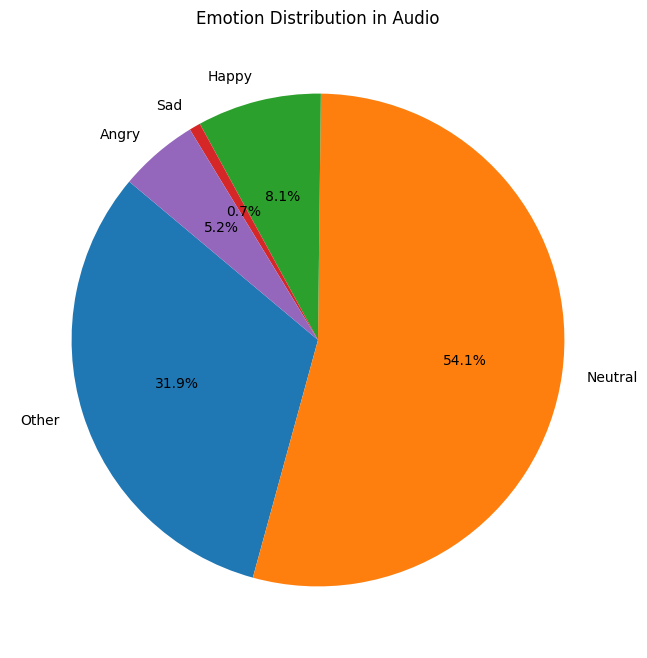

In [5]:
# Running the code

emotions = process_audio('../TobyReturns.mp4', 1)

In [6]:
emotions
emotion_counts = Counter(emotions)
emotion_counts

Counter({'Neutral': 73, 'Other': 43, 'Happy': 11, 'Angry': 7, 'Sad': 1})

### General

A human can change their vocal interaction every 0.3 second, therefore the optimal is to take 3 segmentations of voice every second, however,
with more segmentations there's more processing time, which means for the audio of TobyReturns, instead of 3 minutes, it will take 4 * 3 
minutes, evidentally 12 minutes.



### Time Approximation:

- *Processing*: cpu
- *Libraries loading*: 30 secs
- *Modules loading*: 2 mins
- *function loading*: 0.0 secs
- *Process_video loading on TobyReturns.mp4 & 1 subaudio*: 4 mins 